# Task 1: Predict the global rating score

In this notebook, we will use the files provided by the teacher "numpy_files".

Data is stored in tensors (T,F,H,L) where:

    - T. Number of frames 
    - F. Number of feature maps
    - H,L. Feature map dimension

The proposed architecture will be very similar, changing only the convolutional network part,

### 1. Inicialization

In [34]:
# Imports
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, LSTM, Module, Conv1d
from torch.nn import Conv2d, BatchNorm2d, AdaptiveAvgPool2d, Flatten, Dropout
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses

from collections import Counter

In [2]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()   
print(device)

cuda


In [16]:
# Contants 
PATH_TRAIN_OSATS = "../../OSS_dataset/Train/OSATS.csv"
PATH_TRAIN = "../../OSS_dataset/Train/numpy_files/"
PATH_TRAIN_VIDEOS = "../../OSS_dataset/Train/videos/"

OUTPUT_FOLDER = "./results/"

In [4]:
BATCH_SIZE = 16

In [5]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 2. Data Preparation 

In [6]:
df = pd.read_csv(PATH_TRAIN_OSATS, sep=';')
df.head()

,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
0,AHO729,E-LEARNING,PRE,1,A,P54M,2,1,2,2,1,2,2,1,13
1,AHO729,E-LEARNING,PRE,1,B,P54M,2,1,3,1,2,1,2,1,13
2,AHO729,E-LEARNING,PRE,1,C,P54M,2,1,1,1,1,1,1,1,9
3,AHO729,E-LEARNING,POST,"4,5",A,M45P,4,4,4,3,3,4,3,3,28
4,AHO729,E-LEARNING,POST,"4,5",B,M45P,2,3,4,3,3,4,3,3,25


In [7]:
class GRSDataset(Dataset):
    def __init__(self, path_data, path_label, num_frames=300, transforms=None):
        self.num_frames = num_frames
        self.transforms = transforms

        osats = pd.read_csv(path_label, sep = ';')
        self.labels = (
            osats.groupby("VIDEO")["GLOBA_RATING_SCORE"]
            .mean()
            .round()
            .apply(self.grs_to_class)
            .to_dict()
        )

        self.videos = {
            f.replace(".npz", ""): os.path.join(path_data, f)
            for f in os.listdir(path_data)
            if f.endswith(".npz") and f.replace(".npz", "") in self.labels
        }

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_name = list(self.videos.keys())[idx]
        path = self.videos[video_name]
        
        data = np.load(path)
        video = data["video"]  # (T, F, H, L)
        label = self.labels[video_name]
    
        T = video.shape[0]
        if T >= self.num_frames:
            video = video[:self.num_frames]
        else:
            pad = np.repeat(video[-1][None, :, :, :], self.num_frames - T, axis=0)
            video = np.concatenate([video, pad], axis=0)
    
        video_tensor = torch.tensor(video, dtype=torch.float32)
    
        if self.transforms:
            video_tensor = self.transforms(video_tensor)
    
        return video_tensor, torch.tensor(label, dtype=torch.long)

    @staticmethod
    def grs_to_class(grs):
        if 8 <= grs <= 15:
            return 0  # novice
        elif 16 <= grs <= 23:
            return 1  # intermediate
        elif 24 <= grs <= 31:
            return 2  # proeficient
        elif 32 <= grs <= 40:
            return 3  # specialist
        else:
            return -1  # GRS not in range

In [ ]:
def grs_prepare_data_loaders(test = 0.2, val = 0.1, transforms=None):
    generator = torch.Generator().manual_seed(SEED)

    full_dataset = GRSDataset( path_data=PATH_TRAIN, path_label=PATH_TRAIN_OSATS, transforms=transforms)
    #test_dataset = GRSDataset( path_data=PATH_TEST_REDUCED, path_label=PATH_TEST_OSATS, transforms=transforms)

    total_len = len(full_dataset)
    val_size = int(val * total_len)
    test_size = int(test * total_len)
    train_size = total_len - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)
    
    # DataLoaders 
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dl   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # DataLoaders without Batching
    train_dl_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_dl_all   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_dl_all  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all


In [ ]:
# Not used, but kept for reference
feature_transforms = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
])

In [25]:
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = grs_prepare_data_loaders()

#### 2.1 Visualize Data

In [26]:
def visualize_dataset(train, test, val):
    print(f"Casos de Treino: {len(train.dataset)}")
    print(f"Casos de Validação: {len(val.dataset)}")
    print(f"Casos de Teste: {len(test.dataset)}")

    x, y = next(iter(train)) 
    print(f"(TREINO) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y = next(iter(val)) 
    print(f"(VAL) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y = next(iter(test))
    print(f"(TESTE) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')


In [27]:
visualize_dataset(train_dl, test_dl, val_dl)

Casos de Treino: 221
Casos de Validação: 31
Casos de Teste: 62
(TREINO) Shape tensor batch -> input: torch.Size([16, 300, 384, 20, 20]), output: torch.Size([16])
(VAL) Shape tensor batch -> input: torch.Size([16, 300, 384, 20, 20]), output: torch.Size([16])
(TESTE) Shape tensor batch -> input: torch.Size([16, 300, 384, 20, 20]), output: torch.Size([16])
Valor maximo:7.417194366455078 Valor mínimo:-0.27846458554267883


In [ ]:
def plot_class_distribution(train, test, val, class_names=None):
    def get_class_counts(loader):
        dataset = loader.dataset  # Subset
        counter = Counter()
        for _, label in dataset:
            counter[int(label)] += 1
        return counter

    train_counts = get_class_counts(train)
    test_counts  = get_class_counts(test)
    val_counts   = get_class_counts(val)

    all_classes = sorted(set(train_counts) | set(test_counts) | set(val_counts))
    if class_names is None:
        class_names = [str(c) for c in all_classes]

    train_vals = [train_counts.get(c, 0) for c in all_classes]
    test_vals  = [test_counts.get(c, 0) for c in all_classes]
    val_vals   = [val_counts.get(c, 0) for c in all_classes]

    x = range(len(all_classes))
    bar_width = 0.25

    plt.figure(figsize=(8, 5))
    plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Treino')
    plt.bar(x, test_vals, width=bar_width, label='Teste')
    plt.bar([i + bar_width for i in x], val_vals, width=bar_width, label='Validação')

    plt.xlabel('Classe')
    plt.ylabel('Número de exemplos')
    plt.title('Distribuição de classes por conjunto')
    plt.xticks(ticks=x, labels=class_names)
    plt.legend()
    plt.tight_layout()
    plt.show()

alo
alooo
alooo
alooo


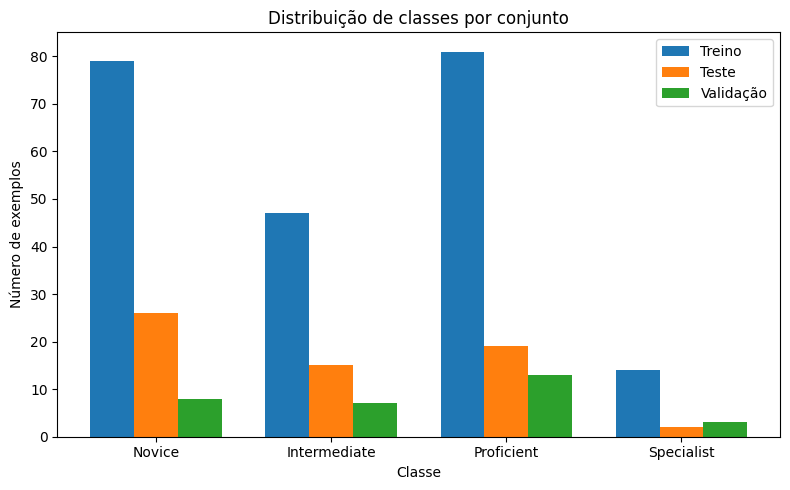

In [33]:
plot_class_distribution(train_dl, test_dl, val_dl, class_names=['Novice', 'Intermediate', 'Proficient', 'Specialist'])

### 3. Model

#### Architecture
- **2D Convolutional Encoder**:
  - Applies two `Conv2d` layers on inputs of shape `(B, 384, 20, 20)`, each followed by ReLU.
  - Uses `BatchNorm2d` after each convolution to stabilize and accelerate training.
  - Applies `AdaptiveAvgPool2d((1, 1))` and `Flatten()` to produce a compact feature vector of shape `(B, 64)` per frame.

- **LSTM-clip**:
  - First LSTM layer that processes the short-range temporal patterns learned by the encoder.
  - Maintains the sequence structure: `(B, T, hidden_clip)`

- **LSTM-video**:
  - Learns long-range temporal dependencies across the entire video.
  - Output remains a sequence: `(B, T, hidden_video)`

- **LSTM-final**:
  - Refines the representation with another LSTM pass.
  - Only the output of the **last timestep** is retained for classification: `(B, hidden_final)`

- **Fully Connected Layer**:
  - Maps the final LSTM representation to GRS class logits: `(B, num_classes)`

#### Input Format
- Expected input shape: `(batch_size, num_frames, 384, 20, 20)`
- Example: a video of 300 frames, each with 384- feature map of dimencion 20x20

#### Output
- Class logits corresponding to the 4 GRS categories: `[Novice, Intermediate, Proficient, Specialist]`


In [ ]:
class GRSModel_02(Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Encoder CNN
        self.frame_encoder = Sequential(
            Conv2d(384, 128, kernel_size=3, padding=1),
            BatchNorm2d(128),
            ReLU(),

            Conv2d(128, 64, kernel_size=3, padding=1),
            BatchNorm2d(64),
            ReLU(),

            AdaptiveAvgPool2d((1, 1)),  # → (B, 64, 1, 1)
            Flatten()  # → (B, 64)
        )

        # cascade LSTMs
        self.lstm_clip = LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm_video = LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.lstm_final = LSTM(input_size=128, hidden_size=64, batch_first=True)

        # Final classificator
        self.classifier = Sequential(
            Dropout(0.3),
            Linear(64, num_classes)
        )

    def forward(self, x):  # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.reshape(B * T, C, H, W)         
        x = self.frame_encoder(x)              # (B*T, 64)
        x = x.reshape(B, T, -1)                # (B, T, 64)

        x, _ = self.lstm_clip(x)
        x, _ = self.lstm_video(x)
        x, _ = self.lstm_final(x)

        return self.classifier(x[:, -1, :])   

In [36]:
model = GRSModel_02().to(device)

### 4. Model Trainning

In [ ]:
#not implemented
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, verbose=True, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.path = path
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                print(f"Validation loss improved. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
def train_model(model, model_path, train_dl, val_dl, criterion, optimizer, scheduler=None, device='cpu', num_epochs=20):
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
        logs = {}

        # ---------- Trainnig ----------
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_dl:
            inputs = inputs.to(device)     # [B, T, F]
            labels = labels.to(device)     # [B]

            optimizer.zero_grad()
            outputs = model(inputs)        # [B, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += (preds == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dl.dataset)
        epoch_train_acc = train_corrects / len(train_dl.dataset)

        logs['loss'] = epoch_train_loss
        logs['accuracy'] = epoch_train_acc

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()

        epoch_val_loss = val_loss / len(val_dl.dataset)
        epoch_val_acc = val_corrects / len(val_dl.dataset)

        logs['val_loss'] = epoch_val_loss
        logs['val_accuracy'] = epoch_val_acc

        # Atualizar scheduler, se existir
        if scheduler:
            scheduler.step(epoch_val_loss)

        # Plot dos logs
        liveloss.update(logs)
        liveloss.send()

    torch.save(model.state_dict(), model_path)


#### 4.1 Hiper-parameters

In [141]:
# Class weigths
all_labels = [int(label.item()) if torch.is_tensor(label) else int(label) for _, label in train_dl_all.dataset]

label_counts = Counter(all_labels)
total = sum(label_counts.values())

num_classes = 4
class_weights = [total / max(label_counts.get(i, 1), 1) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
CRITERION = CrossEntropyLoss(weight=class_weights_tensor)

In [38]:
CRITERION = CrossEntropyLoss()
EPOCHS = 20
LEARNING_RATE = 0.001
OPTIMIZER = Adam(model.parameters(), LEARNING_RATE)
# SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.5, patience=3)

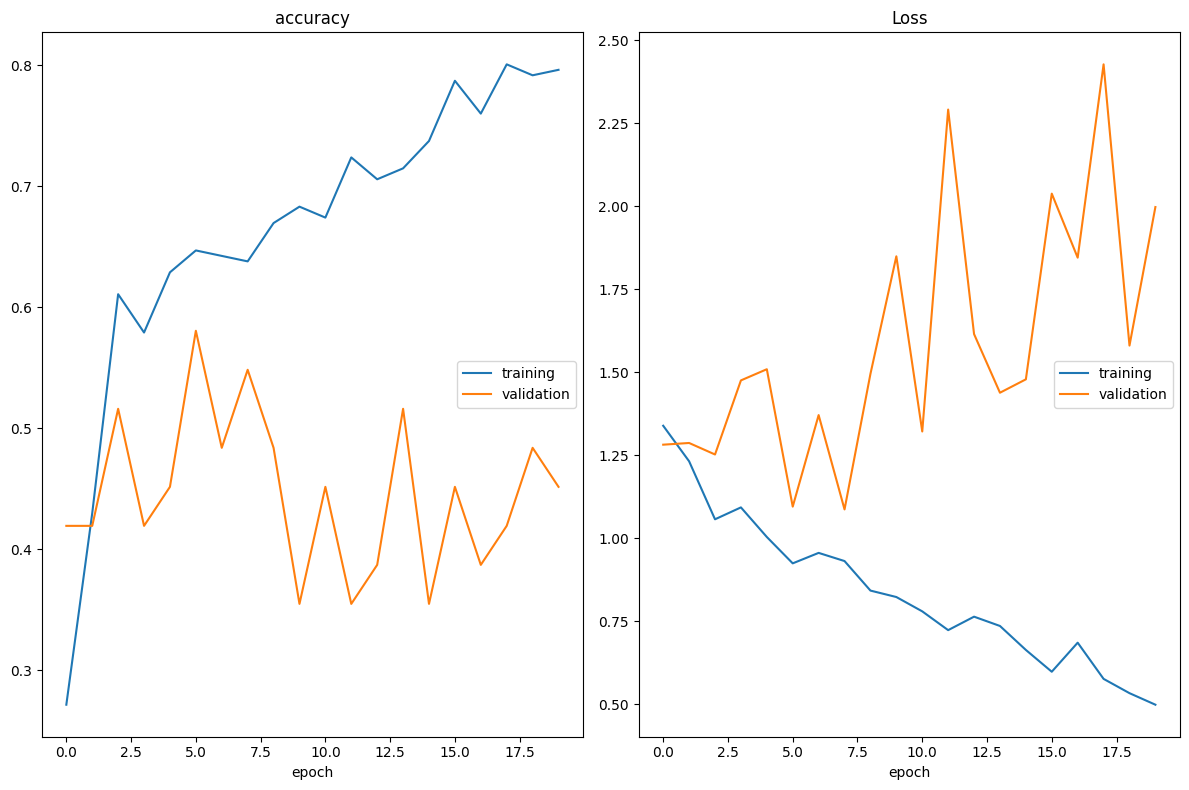

accuracy
	training         	 (min:    0.271, max:    0.801, cur:    0.796)
	validation       	 (min:    0.355, max:    0.581, cur:    0.452)
Loss
	training         	 (min:    0.499, max:    1.339, cur:    0.499)
	validation       	 (min:    1.087, max:    2.427, cur:    1.998)


In [40]:
train_model(
    model=model,
    model_path="grs_02_model.pth",
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    # scheduler=SCHEDULER,
    device=device,
    num_epochs=EPOCHS,
)

### 5. Model Evaluation

#### Calculated Metrics
 - F1-Score
 - Accuracy
 - Expected Cost

In [ ]:
# Export Ground Truth
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

subset = test_dl_all.dataset
base_dataset = subset.dataset
indices = subset.indices

all_video_ids = list(base_dataset.videos.keys())
video_ids = [all_video_ids[i] for i in indices]

labels = [int(label) + 1 for _, label in test_dl_all.dataset]  # +1 to convert to [1–4]

df = pd.DataFrame({
    "VIDEO": video_ids,
    "GRS": labels
})

output_path = os.path.join(OUTPUT_FOLDER, "ground_truth.csv")
df.to_csv(output_path, index=False)
print(f"Saved ground truth to {output_path}")

Saved ground truth to ./results/ground_truth.csv


In [ ]:
# Predict to .csv
def predict_and_export_csv(model_path: str, dataloader, model_class, model_name: str, batch_size=4):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    subset = dataloader.dataset
    base_dataset = subset.dataset
    indices = subset.indices

    video_names = list(base_dataset.videos.keys())
    video_ids = [video_names[i] for i in indices]

    all_inputs = [base_dataset[i][0] for i in indices]

    preds = []

    with torch.no_grad():
        for i in range(0, len(all_inputs), batch_size):
            batch_inputs = torch.stack(all_inputs[i:i+batch_size]).to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())

    # Convert to [1–4]
    preds = [int(p) + 1 for p in preds]

    df = pd.DataFrame({
        "VIDEO": video_ids,
        "GRS": preds
    })

    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    output_path = os.path.join(OUTPUT_FOLDER, f"{model_name}_results.csv")
    df.to_csv(output_path, index=False)
    print(f"✅ Saved predictions to {output_path}")


In [ ]:
# Predict and export results
predict_and_export_csv(model_path="grs_02_model.pth", dataloader=test_dl_all, model_class=GRSModel_02, model_name="grs_02")

✅ Saved predictions to ./results/grs_02_results.csv


#### It is not possible to run the file provided by the teachers, we will calculate the metrics manually

F1-score (macro / DSC): 0.4124
Expected Cost: 0.5161


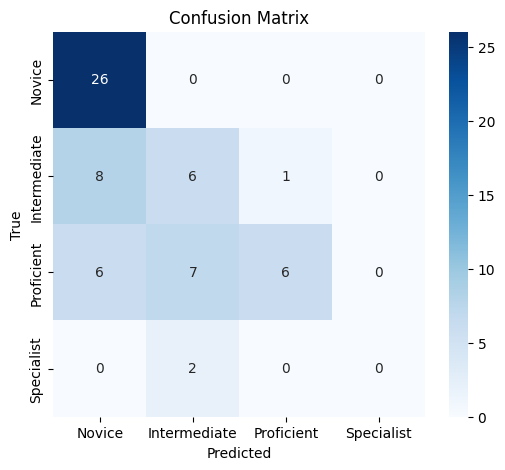

In [47]:
GROUND_TRUTH_PATH = "results/ground_truth.csv"
PREDICTIONS_PATH = "results/grs_02_results.csv"
NUM_CLASSES = 4

df_gt = pd.read_csv(GROUND_TRUTH_PATH)
df_pred = pd.read_csv(PREDICTIONS_PATH)

# Merge
df = pd.merge(df_gt, df_pred, on="VIDEO", suffixes=('_gt', '_pred'))
df = df.rename(columns={"GRS_gt": "ground_truth", "GRS_pred": "prediction"})

# [1-4] -> [0-3]
df[["ground_truth", "prediction"]] = df[["ground_truth", "prediction"]] - 1

# F1 macro
f1 = f1_score(df["ground_truth"], df["prediction"], average='macro')
print(f"F1-score (macro / DSC): {f1:.4f}")

# Expected Cost
cost_matrix = [[abs(i - j) for j in range(NUM_CLASSES)] for i in range(NUM_CLASSES)]
expected_cost = np.mean([
    cost_matrix[gt][pred]
    for gt, pred in zip(df["ground_truth"], df["prediction"])
])
print(f"Expected Cost: {expected_cost:.4f}")

# Confusion Matrix 
cm = confusion_matrix(df["ground_truth"], df["prediction"])
class_names = ["Novice", "Intermediate", "Proficient", "Specialist"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()